In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Bounding boxes and XAI within Chest X-Ray14 dataset

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [2]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}images/"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

num_labels = 14

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 

In [3]:
df_bbox = pd.read_csv(file_path_bbox)
df_bbox.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [4]:
file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
df_data_entry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = images_path + merged_df['Image Index']
merged_df.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,Atelectasis,...,13118,69,M,PA,2992,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,Atelectasis|Effusion|Mass,...,14716,53,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,Atelectasis,...,29817,67,F,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,Atelectasis|Cardiomegaly|Consolidation,...,14687,51,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,Atelectasis,...,17877,75,F,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## look at image index

I want to know which images has more than one bounding box related to the image

In [6]:
image_index_counts = merged_df.groupby('Image Index').size()

# Convert to DataFrame for better handling and sort
image_index_counts_df = image_index_counts.reset_index(name='Count').sort_values(by='Count', ascending=False)
image_index_counts_df

,Image Index,Count
204,00010277_000.png,4
279,00012376_010.png,3
633,00021703_001.png,3
220,00010828_039.png,3
327,00013659_019.png,3
...,...,...
312,00013249_052.png,1
313,00013272_005.png,1
314,00013285_026.png,1
315,00013310_057.png,1


Here one can see that some images has more than one bbox related to the images

## plot bounding boxes with xrays

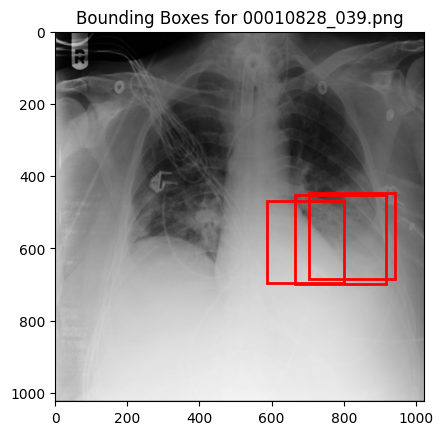

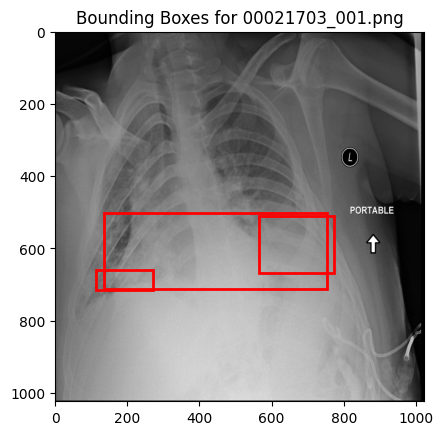

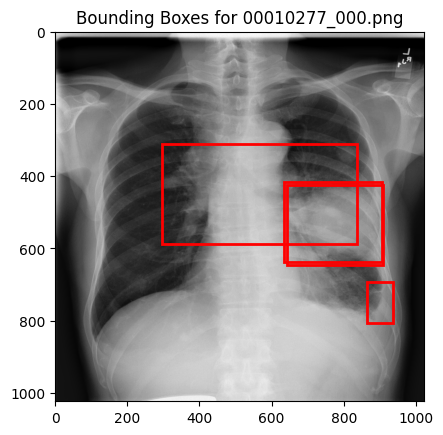

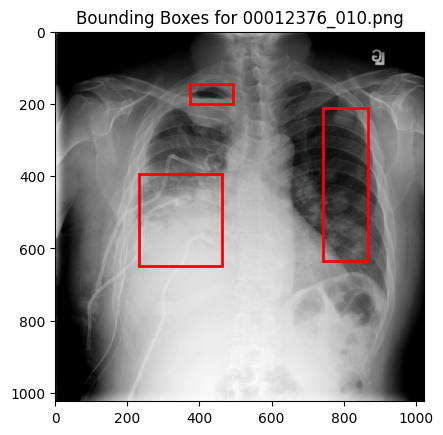

In [7]:
# Filter the DataFrame to include only those with multiple bounding boxes
multi_boxes = merged_df[merged_df['Image Index'].isin(['00010277_000.png', '00012376_010.png', '00021703_001.png', '00010828_039.png'])]

# Define the base path for the images
base_path = '/cluster/home/taheeraa/datasets/chestxray-14/images/'

# Loop through the unique images that have more than one bounding box
for image_index in multi_boxes['Image Index'].unique():
    # Load the image
    img_path = base_path + image_index
    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')
    
    # Get rows for the current image
    rows = multi_boxes[multi_boxes['Image Index'] == image_index]
    
    # Draw each bounding box
    for idx, row in rows.iterrows():
        # Create a rectangle patch
        rect = patches.Rectangle((row['x'], row['y']), row['w'], row['h'], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # Display the image
    plt.title(f"Bounding Boxes for {image_index}")
    plt.show()


In [8]:
def hacky():    
    img_path = base_path + img_index

    # Define specific colors
    colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
    unique_labels = df_filtered['Finding Label'].unique()
    if len(unique_labels) > len(colors_list):
        print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
    label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')

    # Draw each bounding box with its corresponding label
    for idx, row in df_filtered.iterrows():
        # Extract coordinates and label
        x, y, w, h = row['x'], row['y'], row['w'], row['h']
        label = row['Finding Label']
        color = label_color_map[label]

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text with a background color matching the bounding box
        ax.text(x, y, label, verticalalignment='top', color='black', fontsize=8, weight='bold', 
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # Display the image
    plt.title(f"{img_index}.png")
    plt.show()

In [9]:
image_index_counts_df.head(20)

,Image Index,Count
204,00010277_000.png,4
279,00012376_010.png,3
633,00021703_001.png,3
220,00010828_039.png,3
327,00013659_019.png,3
113,00005066_030.png,3
598,00020482_032.png,3
170,00008814_010.png,3
506,00018253_059.png,3
516,00018427_004.png,3


# Inference with gradcam
00021703_001, 00005066_030, 00027441_002

In [22]:
img_id = "00021703_001"
img_index = f"{img_id}.png"
df_filtered = merged_df[merged_df['Image Index'] == img_index]
df_filtered

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
315,00021703_001.png,Effusion,563.768889,511.184601,208.213333,155.875556,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
469,00021703_001.png,Infiltrate,113.208889,659.095712,158.151111,55.751111,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
973,00021703_001.png,Atelectasis,136.362674,500.811858,616.675556,212.764444,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## loading model

In [11]:
#pretrained_weights = "/cluster/home/taheeraa/code/master-thesis/01-multi-label/output/2024-05-23-13:36:36-fine-tuned-swin/swin_base_simmim_run_0.pth.tar"
#checkpoint = torch.load(pretrained_weights)
#state_dict = checkpoint['state_dict']
#model = timm.create_model('swin_base_patch4_window7_224', num_classes=num_labels)

pretrained_weights = "/cluster/home/taheeraa/code/BenchmarkTransformers/Models/Classification/ChestXray14/06-transformers-pre-trained/vit_base_imagenet_1k_sgd_64_bce_True/vit_base_imagenet_1k_sgd_64_bce_True_run_0.pth.tar"
checkpoint = torch.load(pretrained_weights)
state_dict = checkpoint['state_dict']
model = timm.create_model('vit_base_patch16_224', num_classes=num_labels, pretrained=True)

msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))

Loaded with msg: <All keys matched successfully>


## prepare data

In [12]:
def load_and_preprocess_images(image_paths,normalize="chestx-ray"):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
        
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to the same size expected by the model
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    images = [transform(Image.open(path).convert('RGB')) for path in image_paths]
    batch = torch.stack(images)  # Stack images into a single batch
    return batch

img_filenames = [f'{img_index}']
img_paths = [f"{images_path}/{filename}" for filename in img_filenames]

input_tensor = load_and_preprocess_images(img_paths)
input_tensor.size()

torch.Size([1, 3, 224, 224])

## model inference

In [13]:
def predict(model, batch):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        logits = model(batch)  # Forward pass
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities for multilabel classification
    return probabilities

# Perform inference
probabilities = predict(model, input_tensor)

## prediction

tensor([[1.4135e-01, 4.3021e-02, 7.3753e-02, 3.4304e-01, 1.7021e-02, 9.8417e-03,
         1.9611e-02, 3.0621e-02, 7.8795e-02, 7.2099e-02, 9.3246e-03, 5.0060e-04,
         1.5237e-02, 2.9169e-04]])
tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


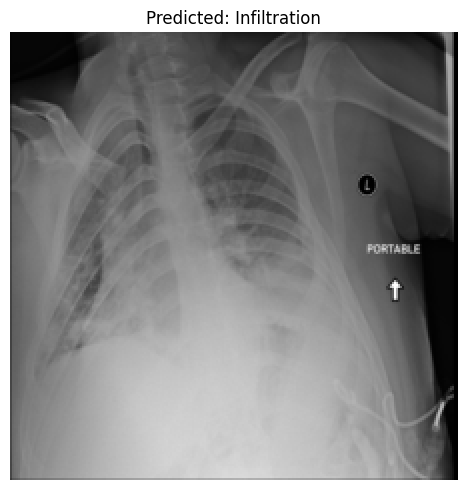

[3]: ['Infiltration']


In [14]:
import torchvision.transforms.functional as F

def plot_images_with_predictions(image_paths, labels, predictions, img_size):
    # Number of images
    num_images = len(image_paths)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(10, num_images * 5))
    
    # Flatten the axes array for easy iteration if only one row exists
    if num_images == 1:
        axes = [axes]
    
    # Loop through images, predictions, and the corresponding axes
    for idx, (path, ax) in enumerate(zip(image_paths, axes)):
        # Open and resize image
        image = Image.open(path).convert('RGB')
        image = F.resize(image, (img_size, img_size))
        
        # Display the image
        ax.imshow(image)
        ax.axis('off')  # Turn off axis
        
        # Get predicted labels
        predicted_labels = [label for label, pred in zip(labels, predictions[idx]) if pred == 1]
        
        # Set title with predicted labels
        ax.set_title("Predicted: " + ", ".join(predicted_labels))
    
    plt.tight_layout()
    plt.show()

# Convert probabilities to binary predictions based on a threshold
threshold = 0.2
print(probabilities)
predicted_labels = (probabilities > threshold).int()
print(predicted_labels)

# Now plot the images with their predicted labels
plot_images_with_predictions(img_paths, labels, predicted_labels, img_size=224)

indices = torch.nonzero(predicted_labels == 1)
pred_indices = indices[:, 1]
pred_indices = pred_indices.tolist()

pred_labels = [labels[i] for i in pred_indices]
print(f"{pred_indices}: {pred_labels}")

## looking at xai

In [16]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1):

In [17]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [21]:
import cv2

model.eval()
print(image_path)
image_path = images_path + img_index

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert grayscale to RGB
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
rgb_img.shape
input_tensor.shape

/cluster/home/taheeraa/datasets/chestxray-14/images/00021703_001.png


torch.Size([1, 3, 224, 224])

In [19]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion='mean', 
    discard_ratio=0.8)
mask = attention_rollout(input_tensor)
name = "attention_rollout_{:.3f}_{}.png".format(0.9, 'mean')
mask.shape

Doing Attention Rollout


(14, 14)

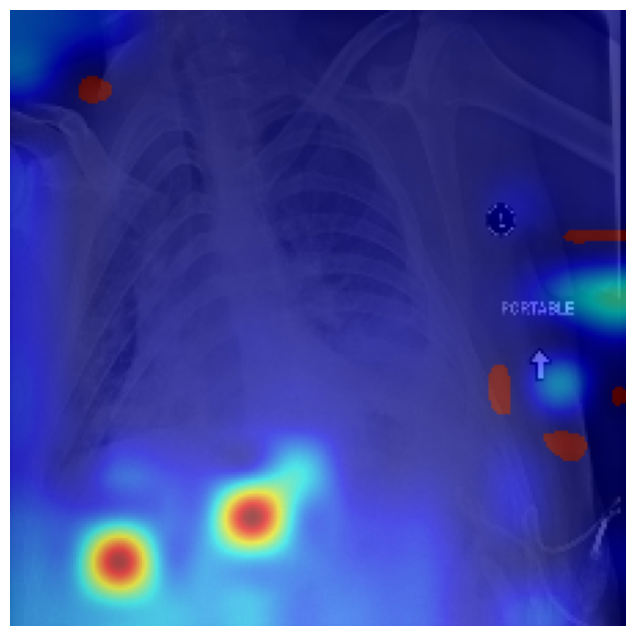

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'mask' is the (14, 14) attention mask and 'rgb_img' is the original RGB image
# Resize the mask to match the image dimensions used by the model (224x224)
mask_resized = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_CUBIC)
mask_normalized = mask_resized / mask_resized.max()

# Convert the normalized mask to a heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * mask_normalized), cv2.COLORMAP_JET)

# Ensure 'rgb_img' is resized to (224, 224) if not, resize it
if rgb_img.shape[:2] != (224, 224):
    rgb_img = cv2.resize(rgb_img, (224, 224))

# Blend the heatmap with the original image
alpha = 0.6  # Transparency for the heatmap
overlayed_image = cv2.addWeighted(heatmap, alpha, rgb_img, 1 - alpha, 0)

# Convert BGR to RGB for matplotlib
overlayed_image_rgb = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.figure(figsize=(8, 8))  # Set the figure size as needed
plt.imshow(overlayed_image_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
